
# <font color="blue">Objective:</font> 
### <font color="orange">Use Swin Transformer on any dataset of choice and prepare end to end pipeline</font> 
## Assignment Details:

Complete the below mentioned tasks as a part of your Assignment.
• This is an individual assignment.
• A reference paper link has been attached below in the submission guidelines.
• Please attempt to solve the following question:
1.Use Swin Transformer on any dataset of choice and prepare end to end pipeline
## Outcome: Participants will be able to work and solve on the Swin Transformer

## Pawpularity: Swin Transformer from Scratch
### Table of Contents
- Summary
- Setup
- Configuration
- Helpers
- Import datasets
- Data Preprocessing
- Model Development
- Submission
- Reference

### Summary
In this Notebook, I will create a Swin Transformer From Scratch.

### Setup

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow_addons as tfa

## Configuration

In [2]:
class Config:
    
    image_size = 128
    
    input_shape = [image_size, image_size, 3]
    
    patch_size = [8, 8]
    
    num_patch_x = input_shape[0] // patch_size[0]
    
    num_patch_y = input_shape[1] // patch_size[1]
    
    learning_rate = 1e-3
    
    num_mlp = 256
    
    dropout_rate = 0.03
    
    weight_decay = 0.0001
    
    batch_size = 128
    
    num_classes = 1
    
    num_epochs = 30
    
    num_heads = 8
    
    label_smoothing = 0.1
    
    embed_dim = 64 
    
    window_size = 2 
    
    tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

config = Config()

## Helpers

### Display images

In [3]:
def display_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

## Data Augmentation

In [4]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))


def data_augment(image):
    #image = tf.image.random_crop(image, (Config.image_size, config.image_size))
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image

### Preprocess datasets

In [5]:
def preprocess_image(image_url, augment):
    
    image_string = tf.io.read_file(image_url)
    
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    if augment == True:
        image = data_augment(image)
    image = tf.image.resize(image, (Config.image_size, Config.image_size))
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

def preprocess_train(image_url, tabular):
    tabular = tf.cast(tabular, tf.float32)
    return (preprocess_image(image_url, True), tabular[1:]), tabular[0]

def preprocess_valid(image_url, tabular):
    tabular = tf.cast(tabular, tf.float32)
    return (preprocess_image(image_url, False), tabular[1:]), tabular[0]

def preprocess_test(image_url, tabular):
    tabular = tf.cast(tabular, tf.float32)
    return (preprocess_image(image_url, False), tabular), 0


### RMSE Loss Function

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

## Import datasets

In [7]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")

## Data Preprocessing

In [8]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
train["file_path"] = train["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [10]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


<AxesSubplot:>

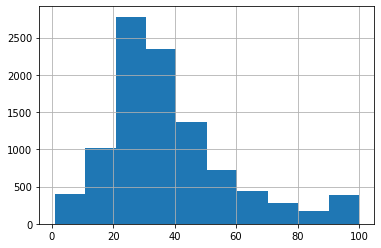

In [11]:
train["Pawpularity"].hist()

### Images with High Scores

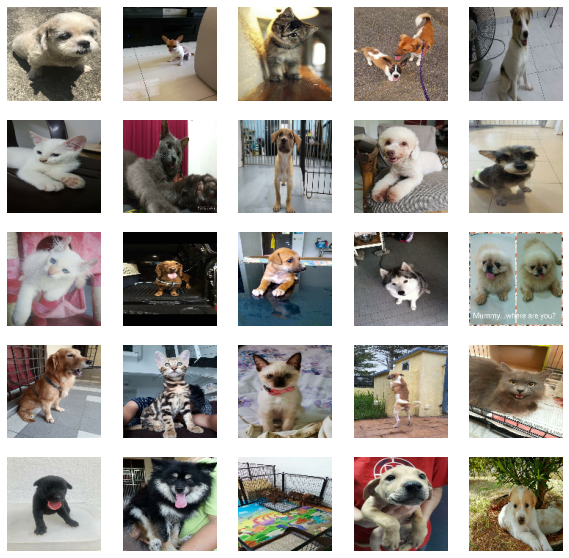

In [12]:
item_width = 5
data = train[train.Pawpularity >= 90]
for item in tf.data.Dataset.from_tensor_slices((data["file_path"], data[["Pawpularity"] + Config.tabular_columns])).map(preprocess_valid).batch(item_width ** 2).take(1):
    display_images(item[0][0].numpy(), item_width, item_width)

### Images with Low Scores

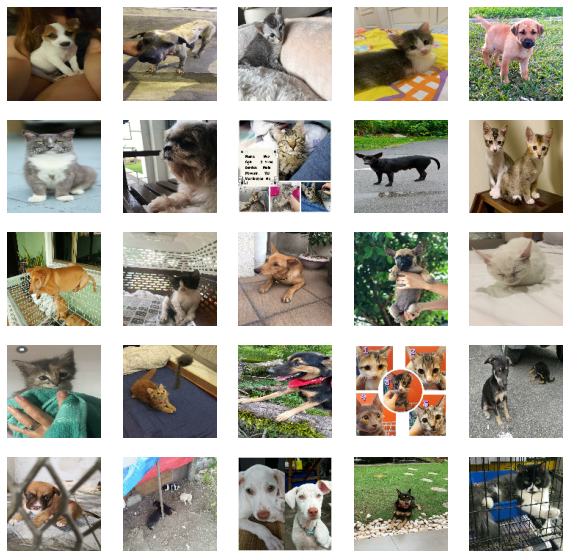

In [13]:
data = train[train.Pawpularity <= 10]
for item in tf.data.Dataset.from_tensor_slices((data["file_path"], data[["Pawpularity"] + Config.tabular_columns])).map(preprocess_valid).batch(item_width ** 2).take(1):
    display_images(item[0][0].numpy(), item_width, item_width)

### Images with median scores

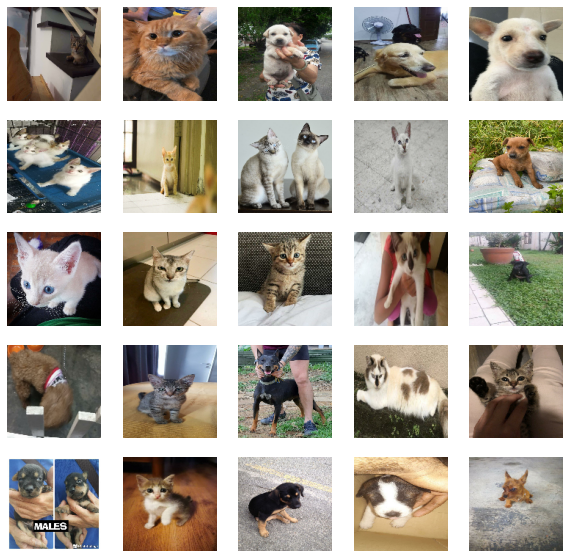

In [14]:
data = train[(train.Pawpularity >= 40) & (train.Pawpularity <= 60)]
for item in tf.data.Dataset.from_tensor_slices((data["file_path"], data[["Pawpularity"] + Config.tabular_columns])).map(preprocess_valid).batch(item_width ** 2).take(1):
    display_images(item[0][0].numpy(), item_width, item_width)

## Model Development

### Helper functions

In [15]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

### Window based multi-head self-attention

In [16]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

### The complete Swin Transformer model

In [17]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False, name="attn_mask")

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

### Extract and embed patches
We first create 3 layers to help us extract, embed and merge patches from the images on top of which we will later use the Swin Transformer class we built.

In [18]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [19]:
def get_swin_transformer(config, inputs):
    x = PatchExtract(config.patch_size)(inputs)
    x = PatchEmbedding(config.num_patch_x * config.num_patch_y, config.embed_dim)(x)
    for shift_size in range(2):
        x = SwinTransformer(
            dim=config.embed_dim,
            num_patch=(config.num_patch_x, config.num_patch_y),
            num_heads=config.num_heads,
            window_size=config.window_size,
            shift_size=shift_size,
            num_mlp=config.num_mlp,
            qkv_bias=True,
            dropout_rate=config.dropout_rate,
        )(x)
    x = PatchMerging((config.num_patch_x, config.num_patch_y), embed_dim=config.embed_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)
    return x

In [20]:
def get_tabular_model(inputs):
    width = 8
    depth = 9
    activation = "relu"
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation
        )(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.Concatenate()([x, inputs])
    return x

In [21]:
def get_model(config, use_tabular_input=True, is_training=True):
    
    image_inputs = keras.Input(shape=config.input_shape)
    tabular_inputs = keras.Input(len(config.tabular_columns))
    image_x = get_swin_transformer(config, image_inputs)
    inputs = [image_inputs, tabular_inputs]
    if use_tabular_input:
        tabular_x = get_tabular_model(tabular_inputs)
        x = layers.Concatenate()([image_x, tabular_x])
    else:
        x = image_x
    output = layers.Dense(1)(x)
    model = keras.Model(inputs, output)
    if is_training:
        model.compile(
            loss=rmse,
            optimizer=tfa.optimizers.AdamW(
                learning_rate=config.learning_rate, 
                weight_decay=config.weight_decay
            ),
            metrics=[
                "mae"
            ],
        )
    return model

Let's have a big picture of how this Model looks like.

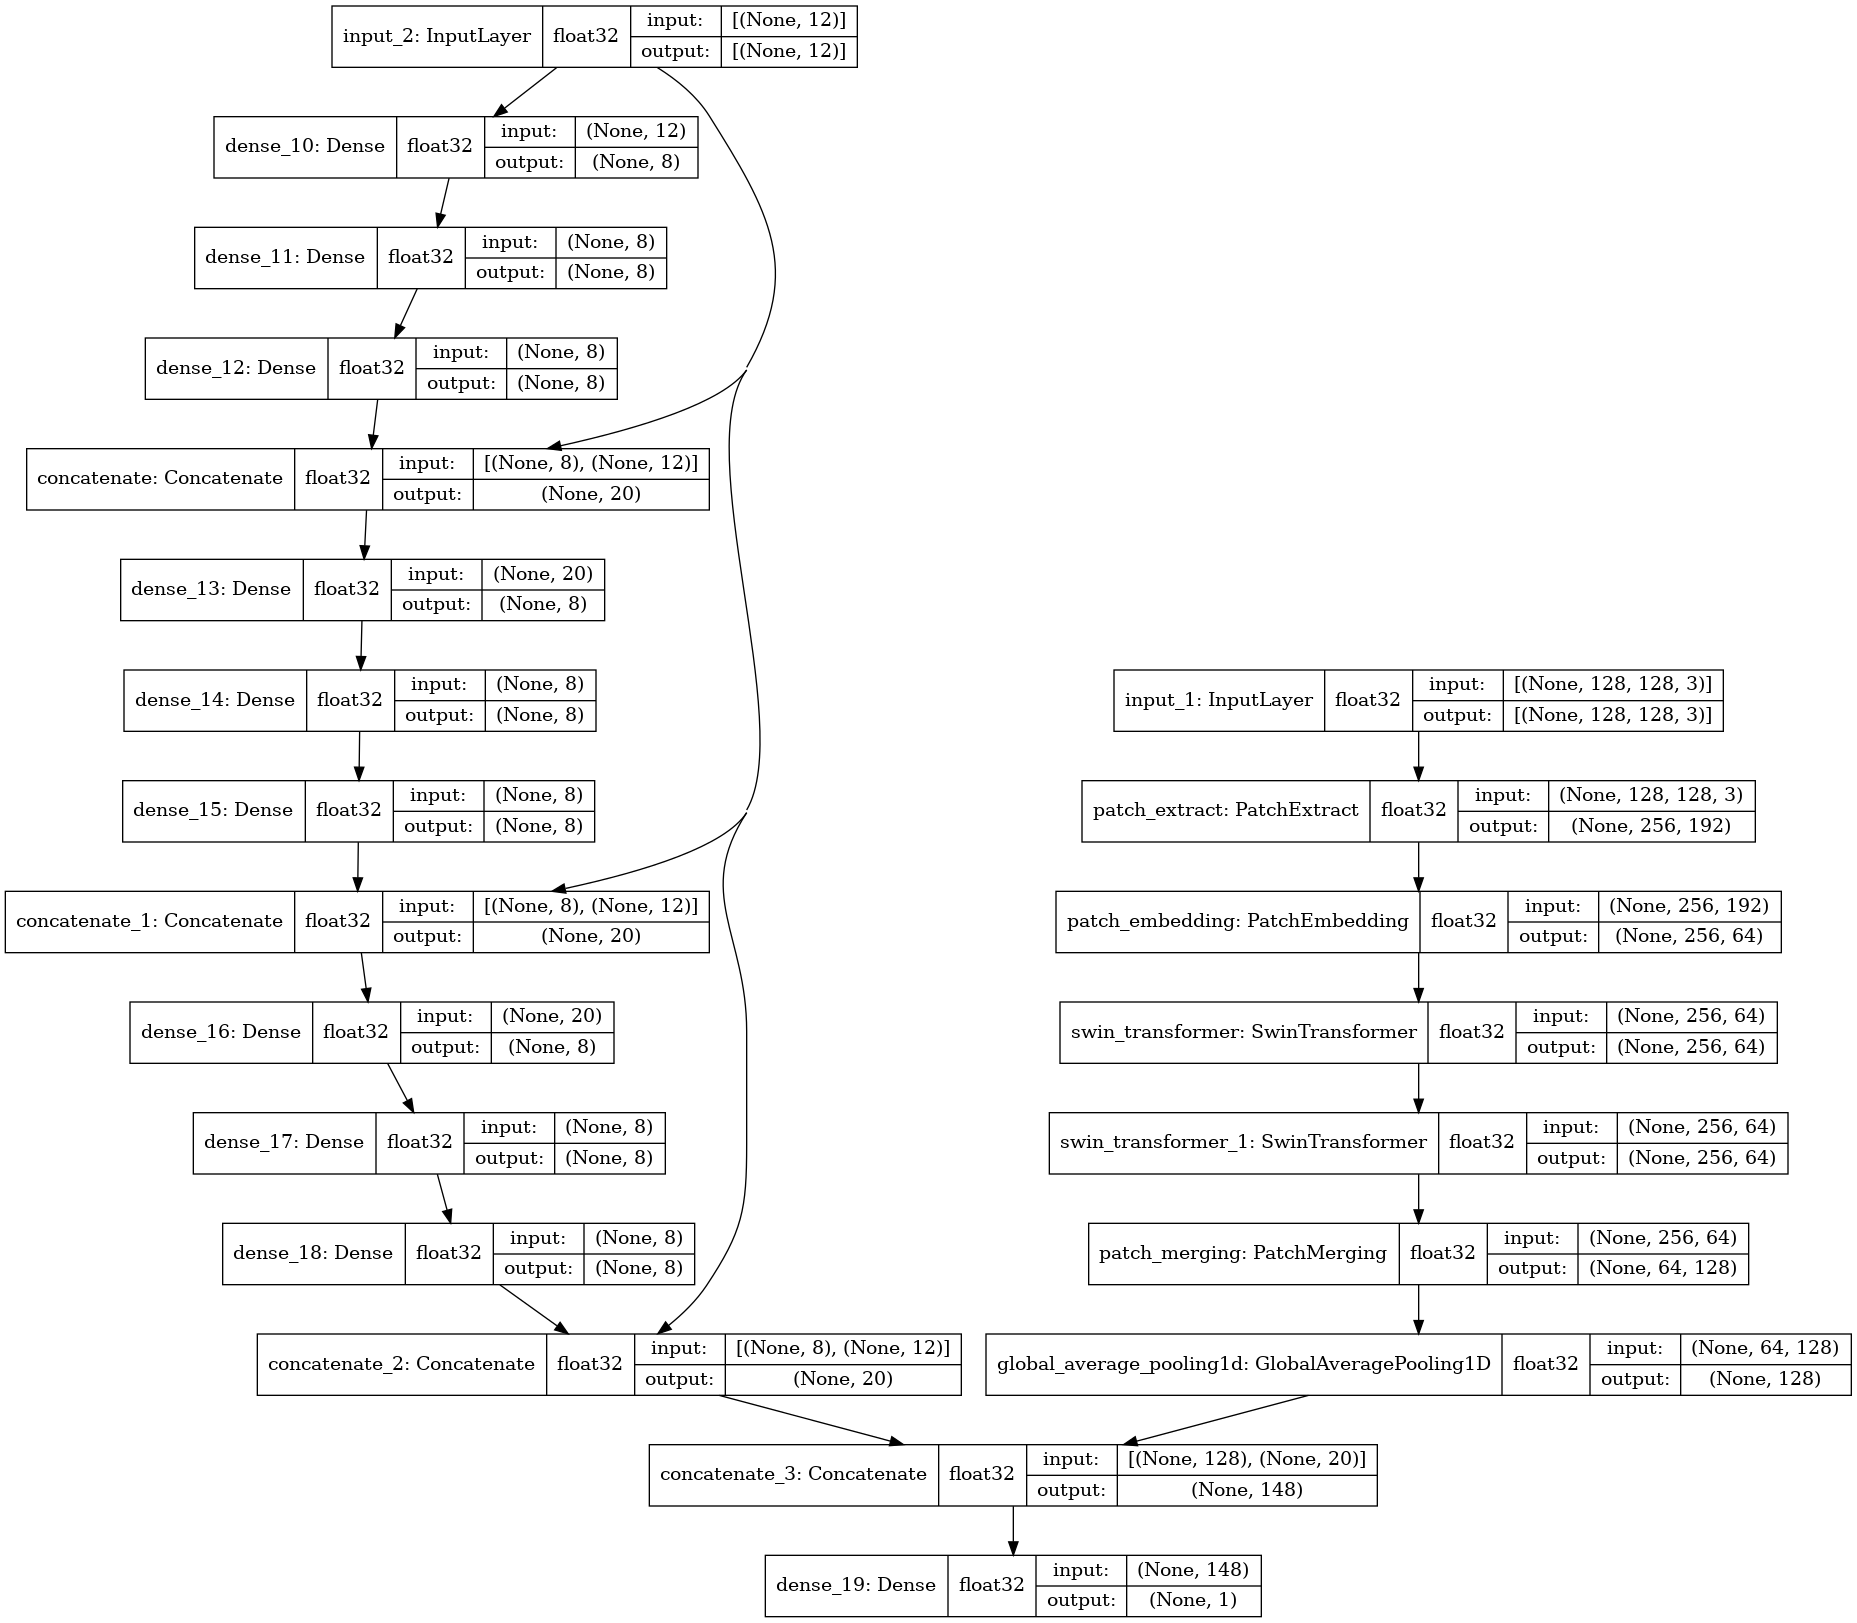

In [22]:
model = get_model(config, is_training=False)
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 8)            104         input_2[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 8)            72          dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 8)            72          dense_11[0][0]                   
______________________________________________________________________________________________

This Model accepts images with shape (image_size, image_size, 3) and tabular information (if needed) with shape (12) as input. It generates output with shape (1). 

In [24]:
image = np.random.normal(size=(1, Config.image_size, Config.image_size, 3))
tabular = np.random.normal(size=(1, len(Config.tabular_columns)))
print(image.shape, tabular.shape)
print(model((image, tabular)).shape)

(1, 128, 128, 3) (1, 12)
(1, 1)


### Model Training
I will use tensorflow Dataset here to preprocess and cache tensors, first epoch is very slow because it's preprocessing data; after that, it would be must faster.

Epoch 1/30
62/62 [==============================] - 232s 3s/step - loss: 24.2533 - mae: 18.7362 - val_loss: 20.3347 - val_mae: 15.6244
Epoch 2/30
62/62 [==============================] - 4s 57ms/step - loss: 21.1357 - mae: 15.9156 - val_loss: 20.3501 - val_mae: 15.6334
Epoch 3/30
62/62 [==============================] - 3s 56ms/step - loss: 21.0472 - mae: 15.8486 - val_loss: 20.5061 - val_mae: 16.1810
Epoch 4/30
62/62 [==============================] - 3s 56ms/step - loss: 21.1186 - mae: 15.8996 - val_loss: 20.2972 - val_mae: 15.7252
Epoch 5/30
62/62 [==============================] - 3s 56ms/step - loss: 20.9398 - mae: 15.7968 - val_loss: 20.2875 - val_mae: 15.6939
Epoch 6/30
62/62 [==============================] - 4s 57ms/step - loss: 20.9403 - mae: 15.7621 - val_loss: 20.2889 - val_mae: 15.6700
Epoch 7/30
62/62 [==============================] - 3s 56ms/step - loss: 20.9432 - mae: 15.7741 - val_loss: 20.3344 - val_mae: 15.8267
Epoch 8/30
62/62 [==============================] - 3s 

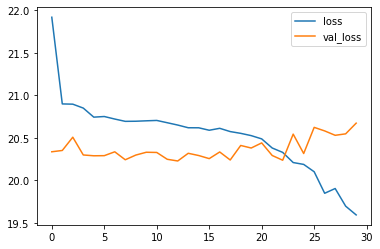

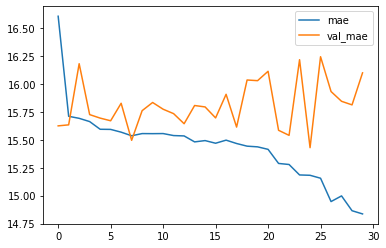

In [25]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=997)
train_on_fold = 4
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_on_fold and index != train_on_fold:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + Config.tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + Config.tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True,
        save_weights_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
   
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-6
    )

    #callbacks = [reduce_lr, early_stop, checkpoint]
    callbacks = []
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess_train).shuffle(512).batch(Config.batch_size).cache().prefetch(1)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess_valid).batch(Config.batch_size).cache().prefetch(1)
    model = get_model(config)
    history = model.fit(train_ds, epochs=config.num_epochs, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("mae", "val_mae")]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    #model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

## Submission

In [26]:

sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[Config.tabular_columns])).map(preprocess_test).batch(Config.batch_size).cache().prefetch(1)

In [27]:
total_results = []
for model in models:
    total_results.append(model.predict(test_ds).reshape(-1))
print(total_results)
results = np.mean(total_results, axis=0)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)

[array([38.598045, 37.184383, 37.447674, 30.808973, 33.95449 , 38.49617 ,
       28.181017, 36.361675], dtype=float32)]


## Reference
- [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
- [Image classification with Swin Transformer](https://keras.io/examples/vision/swin_transformers/)

**If you find my notebook useful, give me an upvote.**